# Bayesian Regression

In this notebook we are going to continue our modelling of field goals, but instead of using a frequentist maximum likelihood approach we shall shift to a Bayesian statistical framework. The data we will be training on are post-2011 for the NFL. We previously trained on pre-2011 data, to line up with the exisiting studies. We did this to show that there are interactions happening in those years that were not accounted for. Let's get started in updating our model for the latest seasons.

In [20]:
import sys
sys.path.append('..')

import pickle
import pandas as pd
from scripts.train import feature_engineering
import mysql.connector
import pymc3 as pm
from util.stats import summary
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

The model has been trained outside of this notebook (see scripts/train.py).

In [2]:
datestring = '200223'
with open(f'../models/logistic_model_{datestring}.pkl', 'rb') as f:
    with open(f'../models/trace_{datestring}.pkl', 'rb') as g:
        model = pickle.load(f)
        trace = pickle.load(g)

In [15]:
res = pd.read_csv('../results/fg_results.csv', index_col=0).rename(
        index=lambda x: x.replace(':', '*'))
res

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-73.6425,16.219,-4.541,0.000,-105.431,-41.854
dist,-0.0895,0.006,-13.874,0.000,-0.102,-0.077
year,0.0391,0.008,4.826,0.000,0.023,0.055
seasons,0.0910,0.029,3.133,0.002,0.034,0.148
cold,-0.1672,0.073,-2.298,0.022,-0.310,-0.025
altitude,0.5700,0.168,3.400,0.001,0.241,0.899
humid,-0.0129,0.061,-0.213,0.832,-0.132,0.106
windy,0.2005,0.301,0.665,0.506,-0.390,0.791
away_game,0.0568,0.079,0.717,0.474,-0.099,0.212
postseason,-0.0048,0.080,-0.059,0.953,-0.162,0.153


In [17]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, '> 2011')
df = feature_engineering(df, res).drop('form', axis=1)
df.head()

,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure,cold*windy,postseason*away_game,windy*dist,pressure*iced,seasons*dist
pid,,,,,,,,,,,,,,,,,,,
518641,1,22,2012,9,0,0,1,0,0,0,0,1,0,0,0,0,0,0,198
518697,1,33,2012,2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,66
518810,1,35,2012,8,0,0,1,1,0,0,0,0,0,0,0,0,35,0,280
518836,0,37,2012,17,0,0,1,1,1,0,0,0,0,0,0,0,37,0,629
518852,1,26,2012,8,0,0,1,1,0,0,0,0,0,0,0,0,26,0,208


In [18]:
sample_data = df.sample(frac=0.1)
x_test = sample_data.drop('good', axis=1)
y_test = sample_data['good']
pm.set_data({'data':x_test}, model=model)
y_pred = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 2000/2000 [00:44<00:00, 45.44it/s]


Text(0, 0.5, 'outcome')

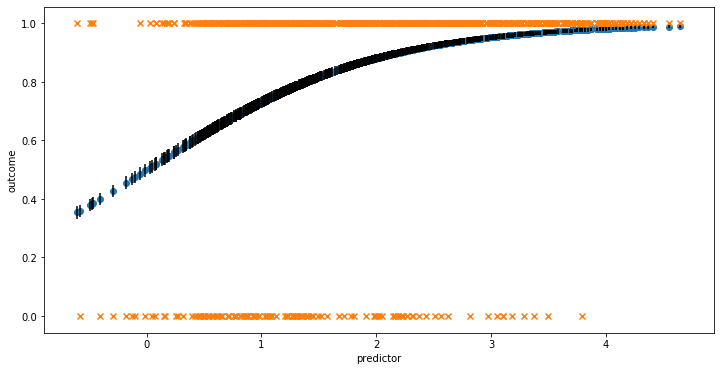

In [21]:
_, ax = plt.subplots(figsize=(12, 6))

beta = st.beta((y_pred['y'] == 1).sum(axis=0), (y_pred['y'] == 0).sum(axis=0))
x = np.log(beta.mean()/(1-beta.mean()))

# estimated probability
ax.scatter(x=x, y=beta.mean())

# error bars on the estimate
plt.vlines(x, *beta.interval(0.95))

# actual outcomes
ax.scatter(x=x,
           y=y_test, marker='x')

# True probabilities
# x = np.linspace(x.min(), x.max())
# ax.plot(x, invlogit(x), linestyle='-')


ax.set_xlabel('predictor')
ax.set_ylabel('outcome')

In [27]:
sample_data['y_pred'] = beta.mean()

In [40]:
sample_data[(sample_data['good']==1) & (sample_data['y_pred']<=0.4)].sort_values('y_pred', ascending=False)

,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure,cold*windy,postseason*away_game,windy*dist,pressure*iced,seasons*dist,y_pred
pid,,,,,,,,,,,,,,,,,,,,
846507,1,63,2019,7,1,0,0,0,0,0,1,1,0,0,0,0,0,0,441,0.3860
520666,1,63,2012,15,0,0,0,1,1,0,0,1,0,0,0,0,63,0,945,0.3835
649802,1,53,2014,11,1,0,1,1,1,1,0,0,1,0,1,1,53,0,583,0.3785
767597,1,62,2017,12,0,0,0,0,1,1,1,0,0,0,0,1,0,0,744,0.3540


In [33]:
weird_pid = tuple(sample_data[(sample_data['good']==0) & (sample_data['y_pred']>=0.9)].index)
# theyre mostly blocked!!!


(871973,
 796139,
 605980,
 609260,
 735850,
 843952,
 641454,
 714914,
 643450,
 557926,
 810650,
 661411,
 695843,
 700932,
 765303,
 619629,
 748232,
 539859,
 592086,
 583477,
 771382)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000262087CDD48>,
      dtype=object)

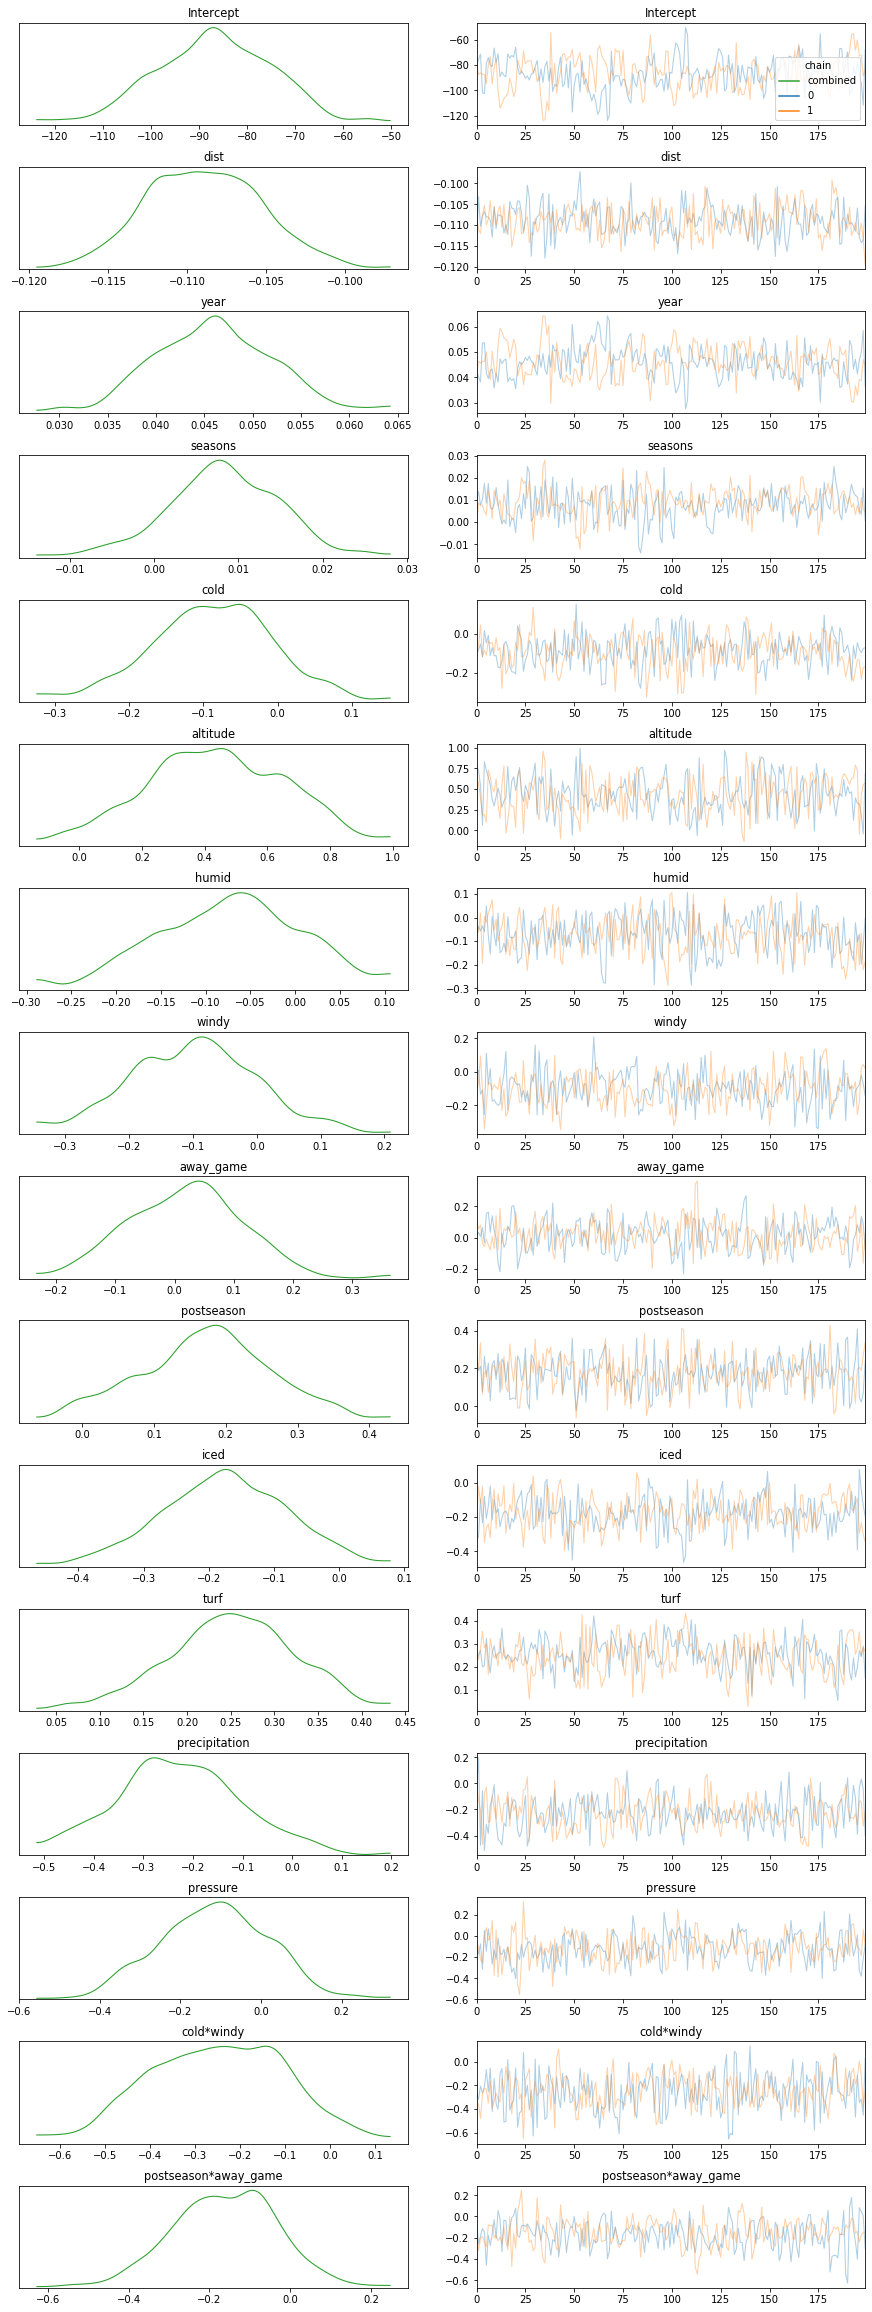

In [49]:
pm.traceplot(trace, legend=True, combined=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002EC76AA3088>,
      dtype=object)

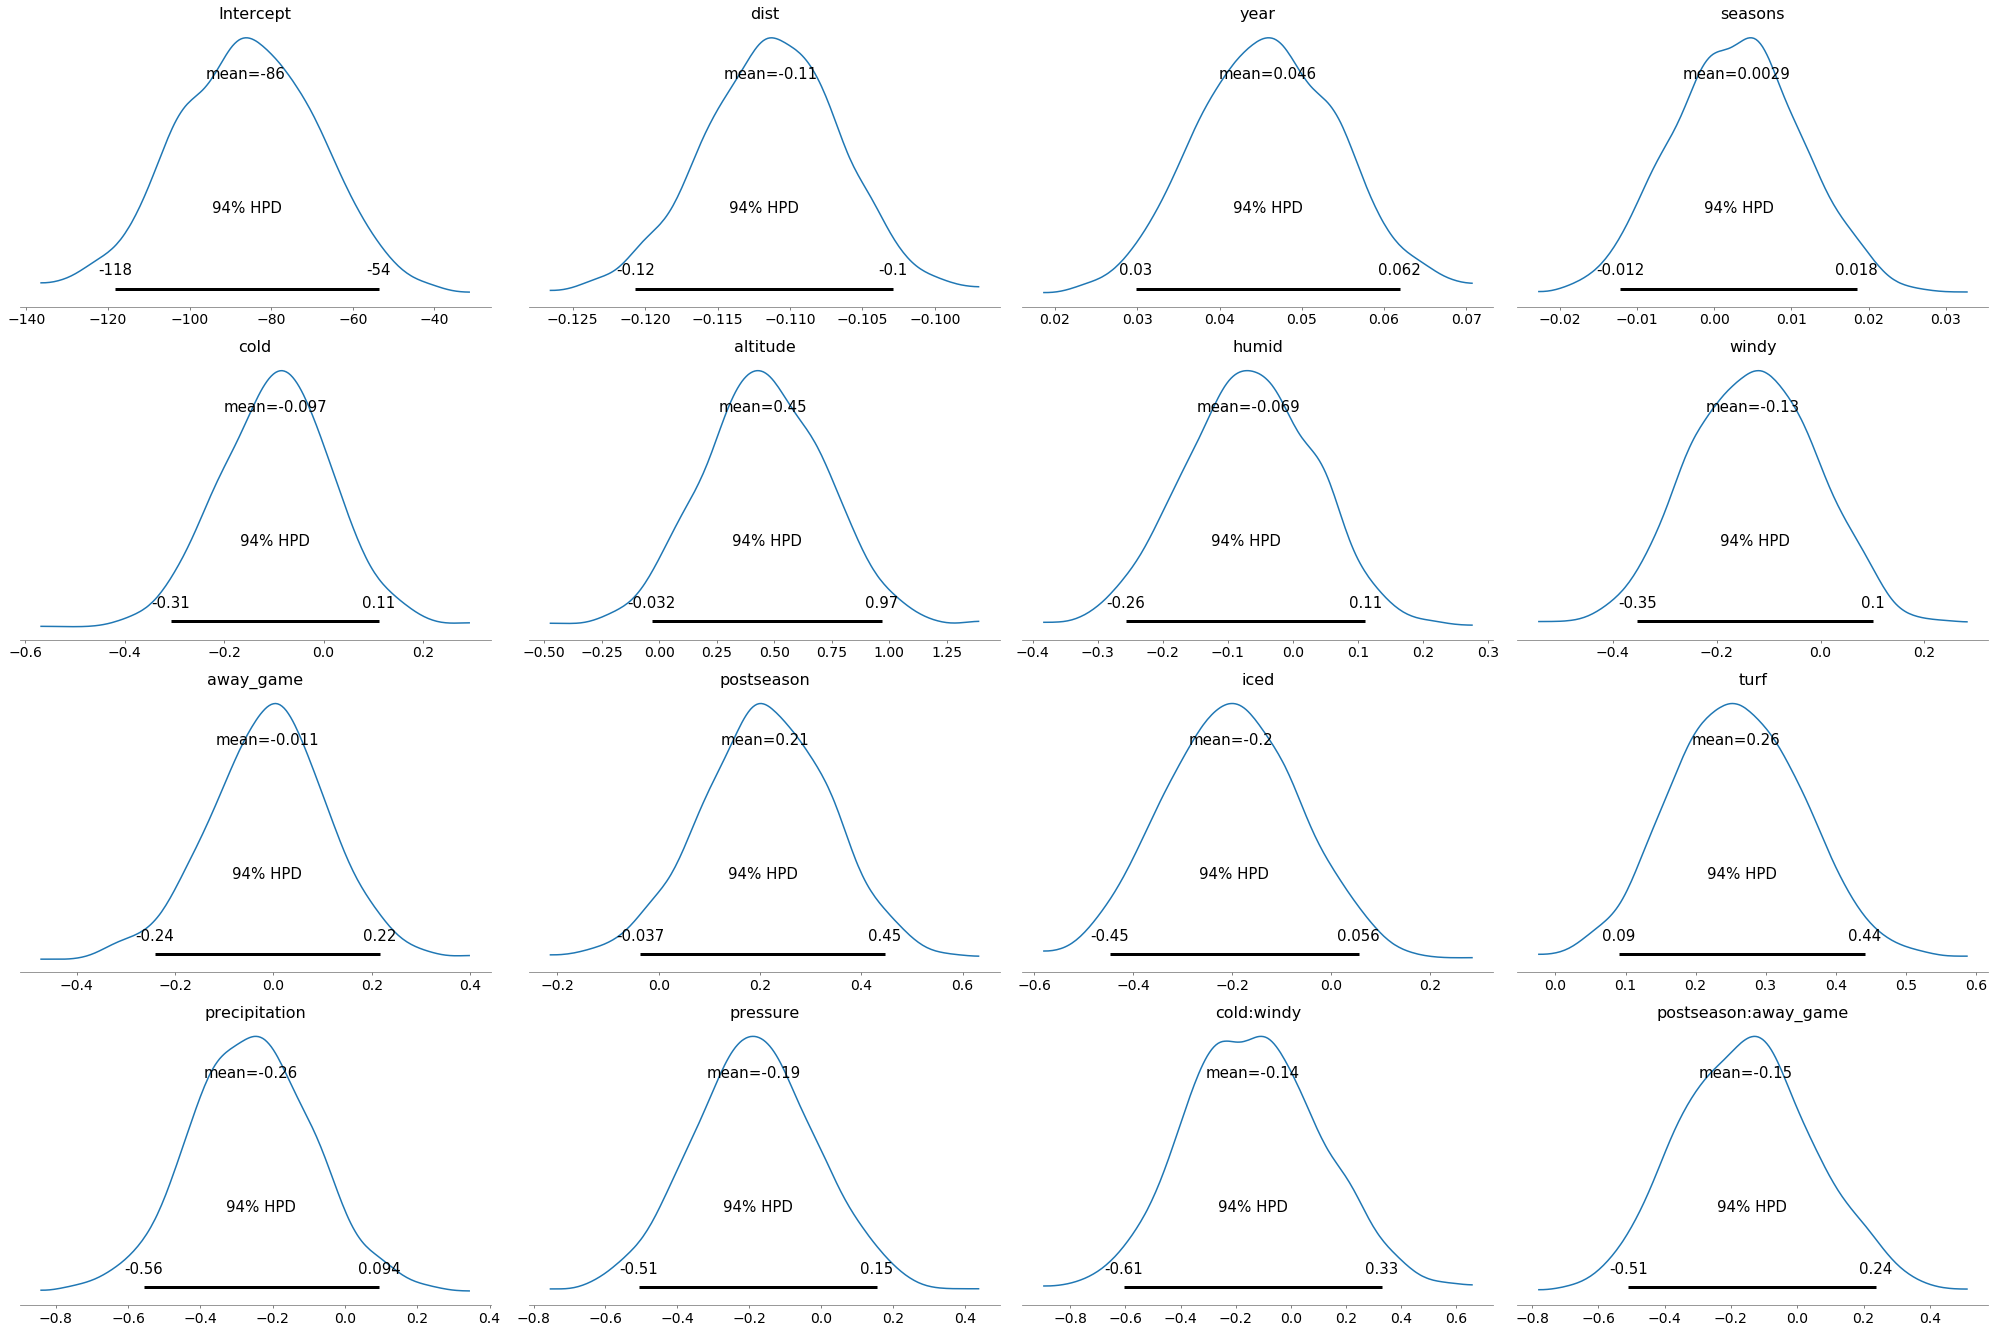

In [3]:
pm.plot_posterior(trace)

In [53]:
summary_ = summary(trace)

In [54]:
summary_

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-86.822320,12.667813,0.871129,-110.648498,-62.281898,121.287842,0.997778
dist,-0.108909,0.003655,0.000195,-0.116395,-0.102350,309.330933,0.997881
year,0.046018,0.006268,0.000431,0.033889,0.057972,121.586657,0.997780
seasons,0.008203,0.006735,0.000377,-0.005757,0.021112,211.638760,1.008788
cold,-0.088474,0.082467,0.004739,-0.240269,0.077893,279.419191,1.000382
altitude,0.435372,0.224005,0.011180,-0.051444,0.806806,354.377893,0.997758
humid,-0.073780,0.080041,0.004459,-0.224898,0.076007,283.774610,0.998348
windy,-0.098229,0.099564,0.005458,-0.268173,0.126041,295.003693,0.999384
away_game,0.018984,0.095593,0.004948,-0.169279,0.186944,308.776992,0.997948
postseason,0.173467,0.094109,0.004130,-0.011068,0.355050,441.964584,0.997807
